## 5. Data Scientist - Continued

### This notebook looks at some notebook optimizations

In [1]:
from pyspark.ml import Pipeline
from pyspark.ml.classification import DecisionTreeClassifier, LogisticRegression
from pyspark.ml.feature import OneHotEncoder, StringIndexer, VectorAssembler
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
import numpy as np
import pandas as pd
import pyspark.sql.functions as F
from sklearn.metrics import accuracy_score, precision_score, recall_score, roc_auc_score, f1_score

In [2]:
from pyspark.sql import SparkSession
spark = SparkSession.builder \
.appName('Spark - Data Scientist Demo') \
.config('spark.jars', 'gs://spark-lib/bigquery/spark-bigquery-latest.jar') \
.config("spark.jars.packages", "com.google.cloud.spark:spark-bigquery-with-dependencies_2.12:0.18.0") \
.getOrCreate()

In [3]:
spark.conf.get("spark.app.id")
spark.sparkContext._jvm.scala.util.Properties.versionString()

'version 2.12.10'

#### Refactor Table - add a date (day) field
Transform the step-column [1,742] to days [1,31]


In [4]:
project_id = !gcloud config list --format 'value(core.project)' 2>/dev/null
bq_enriched_dataset_name = project_id[0] + '-enriched'
bq_enriched_dataset_name = bq_enriched_dataset_name.replace('-', '_')
bq_enriched_table_path = project_id[0] + ':' + bq_enriched_dataset_name + '.transaction_analysis_enriched' 
bq_enriched_table_path

'thetraining-project:thetraining_project_enriched.transaction_analysis_enriched'

In [5]:
data = spark.read \
.format("bigquery") \
.option("table", bq_enriched_table_path) \
.load()

In [6]:
data = data.drop('type_OHE','features','rawPrediction','probability')
data.cache()

DataFrame[transactionID: string, step: bigint, type: string, amount: double, oldbalanceOrg: double, newbalanceOrig: double, oldbalanceDest: double, newbalanceDest: double, isFraud: bigint, type_Index: double, prediction: double, nameOrig: string, nameDest: string]

In [7]:
data.show(5)

+--------------------+----+--------+----------+-------------+--------------+--------------+--------------+-------+----------+----------+-----------+-----------+
|       transactionID|step|    type|    amount|oldbalanceOrg|newbalanceOrig|oldbalanceDest|newbalanceDest|isFraud|type_Index|prediction|   nameOrig|   nameDest|
+--------------------+----+--------+----------+-------------+--------------+--------------+--------------+-------+----------+----------+-----------+-----------+
|cfb3552e-5dbc-43f...| 253|TRANSFER|2291362.68|   2669873.87|     378511.19|     3058807.3|    5350169.97|      0|       1.0|       1.0|C1781690947| C957571823|
|a17326ba-c2ef-478...| 298|TRANSFER| 1409402.4|   1454579.85|      45177.46|    2667574.16|    4076976.55|      0|       1.0|       1.0| C408803288| C886608142|
|ac02b4ad-fda5-4b7...|   8|TRANSFER|1813989.65|   4706735.19|    2892745.54|     286977.47|    3763219.68|      0|       1.0|       1.0| C823075399| C111636207|
|6030e249-9438-42d...| 183|TRANSFE

In [8]:
pandas_df = data.toPandas()

**TODO** (Challenge 3)
* Convert the column steps into days
* Each step corresponds to one hour. The dataset was created over the span of a month. There are 742 steps which should be converted to 31 days

In [13]:
pandas_df['days'] = pd.to_numeric(pandas_df['step'], downcast='integer')//24 +1

In [14]:
#Check if there are all days - this should output day 1 to 31
sorted(pd.unique(pandas_df['days']).tolist())

[1,
 2,
 3,
 4,
 5,
 6,
 7,
 8,
 9,
 10,
 11,
 12,
 13,
 14,
 15,
 16,
 17,
 18,
 19,
 20,
 21,
 22,
 23,
 24,
 25,
 26,
 27,
 28,
 29,
 30,
 31]

In [15]:
pandas_df['days'] = pandas_df['days'].astype(int)

In [16]:
pandas_df

,transactionID,step,type,amount,oldbalanceOrg,newbalanceOrig,oldbalanceDest,newbalanceDest,isFraud,type_Index,prediction,nameOrig,nameDest,days
0,cfb3552e-5dbc-43fd-90a5-26ac9e699188,253,TRANSFER,2291362.68,2669873.87,378511.19,3058807.30,5350169.97,0,1.0,1.0,C1781690947,C957571823,11
1,a17326ba-c2ef-478a-97ee-a05ee758c12c,298,TRANSFER,1409402.40,1454579.85,45177.46,2667574.16,4076976.55,0,1.0,1.0,C408803288,C886608142,13
2,ac02b4ad-fda5-4b72-890f-254dcfbfad5d,8,TRANSFER,1813989.65,4706735.19,2892745.54,286977.47,3763219.68,0,1.0,1.0,C823075399,C111636207,1
3,6030e249-9438-42de-9157-ebf6cdff718b,183,TRANSFER,1276187.63,1276824.02,636.39,3635498.19,4911685.83,0,1.0,1.0,C1237752424,C1609979141,8
4,e8916598-a7ed-4e44-91fe-1b869bf05751,41,CASH_IN,1609288.13,14259747.33,15869035.45,9689387.75,8153460.09,0,3.0,1.0,C1931735461,C1488425372,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1271923,b1d828c2-1d1f-4f57-9492-e37608049de4,15,DEBIT,20619.01,0.00,0.00,275060.99,295680.00,0,4.0,0.0,C2073163268,C1532809245,1
1271924,9a463e68-16d0-4ab5-9a41-88da98ae2e8a,262,DEBIT,3434.04,0.00,0.00,28344.61,31778.65,0,4.0,0.0,C1859305522,C1854752248,11
1271925,138b4107-f0dc-406d-891d-ea0fab99421b,407,DEBIT,359.56,0.00,0.00,52269.22,52628.78,0,4.0,0.0,C440219434,C16450507,17
1271926,c9b769b7-9f69-4b01-94ce-a09850005c98,282,DEBIT,3553.81,0.00,0.00,119659.11,123212.92,0,4.0,0.0,C2075915786,C1447890231,12


#### Do some further analyis including visualization

In [17]:
ax = pandas_df['type'].value_counts().plot(kind='bar',title="Number per Typ")
ax.set_xlabel("Transaction Type")
ax.set_ylabel("Frequency")

Text(0, 0.5, 'Frequency')

Text(0, 0.5, 'Frequency')

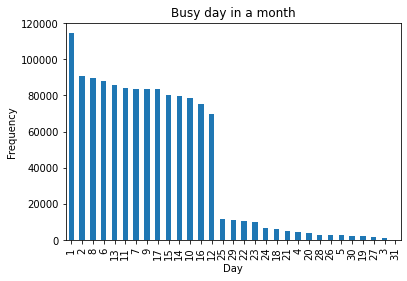

In [18]:
ax = pandas_df['days'].value_counts().plot(kind='bar',title="Busy day in a month")
ax.set_xlabel("Day")
ax.set_ylabel("Frequency")

<AxesSubplot:ylabel='amount'>

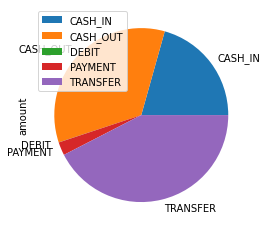

In [19]:
pandas_df.groupby(['type']).sum().plot(kind='pie', y='amount')

#### Store table in a performance opimized way

In [20]:
df = spark.createDataFrame(pandas_df)

In [21]:
bq_optimized_table_name = 'transaction_data_optimized'
bq_optimized_table_path=  project_id[0] +  '_enriched.' + bq_optimized_table_name
bq_optimized_table_path = bq_optimized_table_path.replace('-', '_')
bq_optimized_table_path

'thetraining_project_enriched.transaction_data_optimized'

In [22]:
schema_inline = df.schema.simpleString().replace('struct<', '').replace('>', '').replace('int', 'int64').replace('double', 'float64').replace('bigint64', 'int64').replace('vector', 'STRING').replace('bigint', 'int64')

In [23]:
!bq mk  \
--range_partitioning=days,1,31,1 \
--clustering_fields=days \
{bq_optimized_table_path} \
{schema_inline}

Table 'thetraining-project:thetraining_project_enriched.transaction_data_optimized' successfully created.


In [24]:
df.write \
.format("bigquery") \
.option("table", project_id[0]  + ':' + bq_optimized_table_path) \
.option("temporaryGcsBucket", project_id[0]  + '-data') \
.mode('overwrite') \
.save()

#### Measure performance

In [25]:
bq_partition_table_path = project_id[0] + ':' + bq_enriched_dataset_name + '.transaction_data_optimized' 
bq_partition_table_path

'thetraining-project:thetraining_project_enriched.transaction_data_optimized'

In [26]:
#load data in filter by partition
partitionset = spark.read \
  .format("bigquery") \
  .option("table", bq_partition_table_path) \
  .option("filter", 'days >= 5 AND days < 25') \
  .load()

In [27]:
partitionset = partitionset.select("days", "amount")

In [28]:
aggregation_optimized = partitionset.groupBy('days').agg(F.sum('amount').alias('total_amount'))

In [29]:
%%timeit -r 10
aggregation_optimized.orderBy('total_amount', ascending=False)

7.74 ms ± 776 µs per loop (mean ± std. dev. of 10 runs, 100 loops each)
